# Práctica 5

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
from scipy import io
import scipy.io.wavfile as wav
#from scipy.linalg import toeplitz
plt.rcParams['figure.figsize']=(6,4)

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Implementación-de-cesptrum-de-una-vocal-sintética" data-toc-modified-id="Implementación-de-cesptrum-de-una-vocal-sintética-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Implementación de cesptrum de una vocal sintética</a></span><ul class="toc-item"><li><span><a href="#Cálculo-del-cepstrum" data-toc-modified-id="Cálculo-del-cepstrum-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Cálculo del cepstrum</a></span></li><li><span><a href="#Liftering" data-toc-modified-id="Liftering-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Liftering</a></span></li><li><span><a href="#Recuperación-del-espectro-del-filtro-del-tracto-vocal" data-toc-modified-id="Recuperación-del-espectro-del-filtro-del-tracto-vocal-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Recuperación del espectro del filtro del tracto vocal</a></span></li></ul></li><li><span><a href="#Implementación-de-cepstrum-para-fantasia.wav" data-toc-modified-id="Implementación-de-cepstrum-para-fantasia.wav-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Implementación de cepstrum para fantasia.wav</a></span><ul class="toc-item"><li><span><a href="#Comparación-con-LPC-y-el-espectrograma" data-toc-modified-id="Comparación-con-LPC-y-el-espectrograma-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Comparación con LPC y el espectrograma</a></span></li></ul></li></ul></div>

## Implementación de cesptrum de una vocal sintética

[Text(0,0.5,'Amplitud'), (0, 0.1), Text(0.5,0,'Tiempo [s]')]

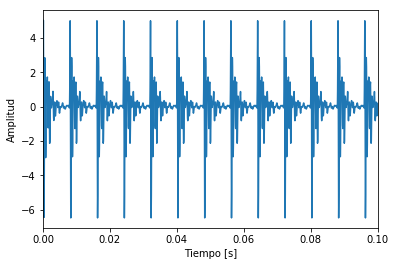

In [2]:
# parámetros
Fs = 16000 # frecuencia de muestreo
F0 = 125   # frecuencia glótica
Fk = [660,1720,2410,3500,4500]
sigmak = [60, 100, 120, 175, 250]
gamma = 0.96
dur=.5 # duración en segundos del audio
# generación de los pulsos glotales
pulsos_glotales = np.zeros(int(dur*Fs))
for i in np.arange(0,pulsos_glotales.size,np.int(Fs/F0)):
    pulsos_glotales[i]=1
# filtrado de la señal por V(z)
b=np.array([1])
a=np.zeros(15)
a.reshape(3,5)
vocal=pulsos_glotales
for i in np.arange(0,5):
    a = np.array([1, -2*np.exp(-2*np.pi*sigmak[i]/Fs)*np.cos(2*np.pi*Fk[i]/Fs),np.exp(-4*np.pi*sigmak[i]/Fs)])
    vocal = signal.lfilter(b,a,vocal)
# filtrado de la señal por R(z)
vocal=signal.lfilter(np.hstack((b,-gamma)),1,vocal)
# generación del audio
audio=vocal/np.max(np.abs(vocal))*32767
wav.write('vocal.wav',Fs,audio.astype('int16'))

# gráfico de la señal filtrada
fig,ax1=plt.subplots()
ax1.plot(np.linspace(0,vocal.size/Fs,vocal.size),vocal)
ax1.set(xlim=[0,0.1],xlabel='Tiempo [s]',ylabel='Amplitud')

[(0, 8000.0), Text(0.5,0,'Frecuencia [Hz]')]

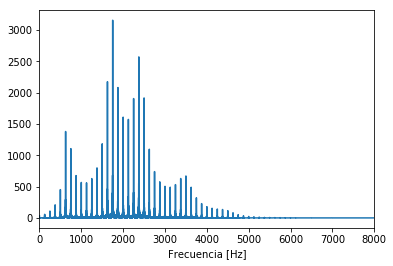

In [3]:
# gráfico del espectro
espectro=np.fft.fft(np.hstack((vocal,np.zeros(vocal.size*7))))
fig,ax1=plt.subplots()
ax1.plot(np.linspace(0,Fs,espectro.size),np.abs(espectro))
ax1.set(xlim=[0,Fs/2],xlabel='Frecuencia [Hz]')

### Cálculo del cepstrum

[Text(0,0.5,'Amplitud'), (0, 0.01), Text(0.5,0,'Quefrency')]

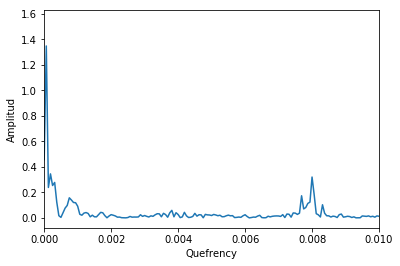

In [4]:
# cepstrum de la señal
cepstrum=np.hstack((vocal,np.zeros(vocal.size*7)))
cepstrum=np.fft.fft(cepstrum)
cepstrum=np.log(cepstrum)
cepstrum=np.fft.ifft(cepstrum)
# gráfico
fig,ax1=plt.subplots()
ax1.plot(np.linspace(0,dur*8,cepstrum.size),np.abs(cepstrum))
ax1.set(xlim=[0,0.010],xlabel='Quefrency',ylabel='Amplitud')

### Liftering

[(3.99, 4.0), Text(0.5,0,'Quefrency')]

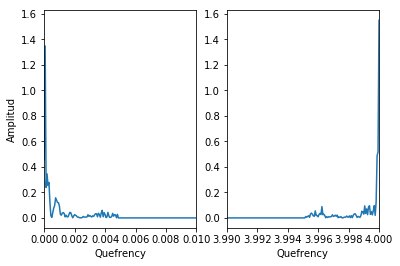

In [5]:
# liftering de la señal
liftering=cepstrum
liftering[np.int(Fs/F0)-50:np.int(-Fs/F0)+50]=0
# gráfico
fig,(ax1,ax2)=plt.subplots(1,2)
ax1.plot(np.linspace(0,dur*8,cepstrum.size),np.abs(liftering))
ax1.set(xlim=[0,.01],xlabel='Quefrency',ylabel='Amplitud')
ax2.plot(np.linspace(0,dur*8,cepstrum.size),np.abs(liftering))
ax2.set(xlim=[dur*8-0.01,dur*8],xlabel='Quefrency')

### Recuperación del espectro del filtro del tracto vocal

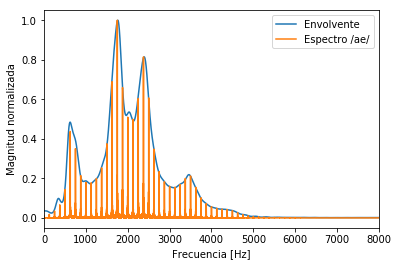

In [6]:
# reconstrucción de la envolvente
envolvente=np.fft.fft(liftering)
envolvente=np.exp(envolvente)

# gráfico
fig,ax1=plt.subplots()
ax1.plot(np.linspace(0,Fs,envolvente.size),np.abs(envolvente)/np.max(np.abs(envolvente)))
ax1.plot(np.linspace(0,Fs,espectro.size),np.abs(espectro)/np.max(np.abs(espectro)))
ax1.set(xlim=[0,Fs/2],xlabel='Frecuencia [Hz]',ylabel='Magnitud normalizada')
ax1.legend(('Envolvente','Espectro /ae/'))

Puede verse que mediante el uso del cepstrum y el liftering se pudo obtener el espectro de la envolvente del fonema /ae/
## Implementación de cepstrum para fantasia.wav

In [7]:
# carga de la señal fantasia.wav
Fs,fantasia=wav.read('fantasia.wav')
# parámetros
dur=.025     # duración en segundos de cada frame
paso=.01     # desplazamiento temporal entre frames
frames=-1    # cantidad de frames para usar. Es -1 para tomar todo el largo del audio
desde=0.5    # tiempo desde el cual tomar los frames
lift_m=40    # muestras que se conservan luego del liftering

# incialización de matriz de espectros
if frames==-1:
    frames=np.int((fantasia.size-dur*Fs)/(paso*Fs))
    desde=0
CEPS_envolventes=np.zeros(frames #filas
                          *np.int(Fs*dur*8),np.complex) #columnas
CEPS_envolventes=CEPS_envolventes.reshape(frames,np.int(Fs*dur*8))
paso_m=np.int(paso*Fs)
dur_m=np.int(dur*Fs)
desde_m=np.int(desde*Fs)
# calculo de las envolventes
for i in np.arange(frames):
    CEPS_envolventes[i,0:dur_m]=fantasia[desde_m+i*paso_m:desde_m+i*paso_m+dur_m]
    CEPS_envolventes[i,:]=np.fft.fft(CEPS_envolventes[i,:])
    CEPS_envolventes[i,:]=np.log(CEPS_envolventes[i,:])
    CEPS_envolventes[i,:]=np.fft.ifft(CEPS_envolventes[i,:])
    CEPS_envolventes[i,lift_m:-lift_m]=0
    CEPS_envolventes[i,:]=np.fft.fft(CEPS_envolventes[i,:])
    CEPS_envolventes[i,:]=np.exp(CEPS_envolventes[i,:])


### Comparación con LPC y el espectrograma
![im1](output_10_1.png)

![im2](output_11_0.png)

[(0, 8000.0)]

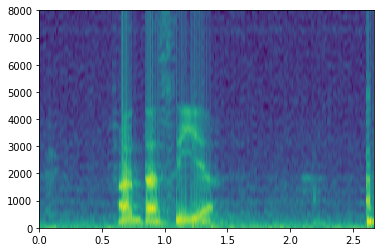

In [8]:
X=np.linspace(desde,desde+paso*frames,frames)
Y=np.linspace(0,Fs,np.int(dur*Fs*8))
fig,ax1=plt.subplots()
ax1.pcolormesh(X,Y,20*np.log(np.abs(CEPS_envolventes.T)))
ax1.set(ylim=[0,Fs/2])

Puede verse que con este proceso, se obtiene una mejor reconstrucción de la envolvente. Con LPC los picos de la envolvente son angostos, en cambio, con cepstrum son mas suaves y dan una mejor idea de como se vería la envolvente.